## Setup

In [ ]:
# google drive access
from google.colab import drive
drive.mount("/content/gdrive")
%cd gdrive/My Drive/ml_tensorflow_git


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/ml_tensorflow_git'
/content/gdrive/My Drive/ml_tensorflow_git


In [ ]:
# git access
git_token = "", # enter git_token.
!git clone https://{git_token}@github.com/fogx/predicting-financial-volatility-project.git

fatal: destination path 'predicting-financial-volatility-project' already exists and is not an empty directory.


In [ ]:
# Setup
## Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn 
import math

## paths
path_data  = "/content/gdrive/MyDrive/ml_tensorflow_git/predicting-financial-volatility-project/resources/data"
path  = "/content/gdrive/MyDrive/ml_tensorflow_git/predicting-financial-volatility-project"
path_code = "/content/gdrive/MyDrive/ml_tensorflow_git/predicting-financial-volatility-project/code"

# **Forecasting financial volatility with neural networks**

**Contributors:** Jule Schüttler, Erik Senn, Leszek Wächter, Leon Wolf

**What is financial (realized) volatility?**
Realized (return) volatility is the standard deviation of (daily) returns. Realized volatility describes the risk connected to a financial asset.

**Project Idea:** Forecast stock volatility tomorrow with stock and macroeconomic data from today and the past.

**Benchmark model:** "Forecast of tomorrow is the volatility of today" (Previous value of volatility as forecast for next value of volatility)



## Abstract & Literature

Accurate forecasts of financial return volatility are relevant for risk and portfolio management, pricing of derivatives and trading. 
We propose to predict the realized volatility of stock returns using neural networks for regression problems, as previously done by Christensen et. al. (2021) and Bucci (2021).

Specifically, we want to forecast daily realized stock return volatility of US stocks based on 11 years high frequency transaction data of the NYSE Trade and Quote database (TAQ).
The statistical out-of-sample forecast performance is compared to the benchmark model.
Realized volatility models need to capture the 2 key empirical properties: strong persistency and volatility clustering (days with high volatility tend to be clustered together, same for low volatility).
In contrast to off-the-shelf neural network implementations in Christensen et. al. (2021), the focus of our work is to test different models and training approaches.
A shortlist of model candidates includes simple feedforward neural networks, autoregressive neural networks, LSTM / GRU.
In addition to past realized volatility as input feature, we use different exogeneous input features such as the implied volatility index in the S&P500 (VIX, markets risk-neural expectation of future realized volatility), daily returns and daily trading volumes.

## Data Description



**Raw Data**

*   Source: Trade and Quote Database from New York Stock Exchange and Chicago Stock Exchange
*   Stocks: BAC (Bank of America)
* Timeframe: 01/2010 to 12/2020 (11 years, 2768 trading days after removing non-business days and missing data)
* 	Additional features: open-close return (sign), VIX, Trading volume. (These variables are only displayed in the preprocessed dataset since they are available per day and not intraday.)

The variation of transaction prices within one day is used to estimate the realized variance of intraday returns for one day.
The code for estimation of realized variance is not provided as it is part of an external project and beyond the scope of this project.

#### Variables
- date: transaction date
- time_m: transaction time
- size: number of shares traded
- price: transaction price of shares traded

The displayed data shows the first 10 transactions on the 2012-10-26. The number of transactions per day is around 30.000-150.000.

In [ ]:
# Intraday Transaction Data
transaction_data_one_day = pd.read_csv(path_data + "/bac_raw_sample.csv")
transaction_data_one_day[["date","time_m","size","price"]]


,date,time_m,size,price
0,2012-10-26,09:30:00.212,12821,9.165
1,2012-10-26,09:30:00.212,12821,9.165
2,2012-10-26,09:30:01.850,500,9.160
3,2012-10-26,09:30:01.850,500,9.160
4,2012-10-26,09:30:01.850,600,9.160
5,2012-10-26,09:30:01.918,500,9.160
6,2012-10-26,09:30:01.918,200,9.160
7,2012-10-26,09:30:01.970,100,9.160
8,2012-10-26,09:30:03.816,117,9.160
9,2012-10-26,09:30:04.162,100,9.160


**Processed Data**

Daily realized variance (from transaction prices) and daily macroeconomic variables.

Generally, the realized variance series does not need to be estimated from intraday data, but can substituted by squared daily returns as proxy. Other time intervals (months instead of days,...) are possible. Other stock sectors or asset types would also be possible as long as the asset is liquid enough to observe sufficient price changes per period (here: day).


#### Variables
- DT - date in YYYYMMDD format (prediction day. prediction target is outcome in DT+1day)
- outcome_rv - realized variance on next day for the given stock based on 5 minute RV estimator
- lag_rv_day - realized variance on the current day (day on which prediction is made)
- lag_rv_day_X - realized variance on the Xth previous day (5 -> lag_5 of outcome_rv. For model with flexible lags)
- lag_rv_week - average realized variance on the past 5 days
- lag_rv_month - average realized variance on the past 22 days (trading month)
- lag_rv_3month - average realized variance on the past 66 days (1 trading quarter)
- vix - implied volatility index of the previous day
- liqudity_day - number transactions on the current day
- liqudity_week - average number transactions on the previous week
- liqudity_month - average number transactions on the previous month
- return_sign_day - sign of open-close-return on the current day
- return_sign_week - sign of open-close-return on the previous week
- return_sign_month - sign of open-close-return on the previous month
- mktMinusRiskfree - market minus riskfree 
- smb - Small Minus Big 
- hml -  High-minus-low 



In [ ]:
# RV
rv_data = pd.read_csv(path_data + "/BAC.csv")
rv_data[~rv_data["lag_rv_month"].isnull()][["DT","outcome_rv","lag_rv_day","lag_rv_week","lag_rv_month","vix","return_sign_day","liquidity_day","mktMinusRiskfree","smb","hml"]]


,DT,outcome_rv,lag_rv_day,lag_rv_week,lag_rv_month,vix,return_sign_day,liquidity_day,mktMinusRiskfree,smb,hml
21,20100203,0.000447,0.000306,0.000419,0.000443,21.60,0,35463.0,1.23,-0.35,0.55
22,20100204,0.001101,0.000447,0.000372,0.000456,26.08,0,68087.0,-0.50,0.02,-0.56
23,20100205,0.000491,0.001101,0.000508,0.000493,26.11,1,69537.0,-3.14,-0.35,-0.69
24,20100208,0.000737,0.000491,0.000530,0.000503,26.51,0,57782.0,0.33,0.05,0.02
25,20100209,0.000433,0.000737,0.000617,0.000520,26.00,0,61794.0,-0.81,0.03,-0.09
...,...,...,...,...,...,...,...,...,...,...,...
2762,20201223,0.000147,0.000115,0.000213,0.000164,23.31,1,40820.0,0.00,1.12,-1.86
2763,20201224,0.000127,0.000147,0.000225,0.000165,21.53,0,20662.0,0.17,0.57,2.06
2764,20201228,0.000097,0.000127,0.000226,0.000160,21.70,0,30192.0,0.00,0.00,0.00
2765,20201229,0.000061,0.000097,0.000119,0.000157,23.08,0,27844.0,0.51,-1.07,0.35


**Descriptives / stylized facts of realized variance**

*   Realized variance is right skewed and >=0. The natural logarithm of realized variance is close to normally distributed.
*   Realized variance is clustered (high values are close to high values, low values are close to low values.
*   Realized variance is persistent over time (high autocorrelation).

Due to these stylized facts, our proposed models capture time dependence either by explicitly including lagged outcomes as features or by states of recurrent neural network type models (LSTM, GRU).

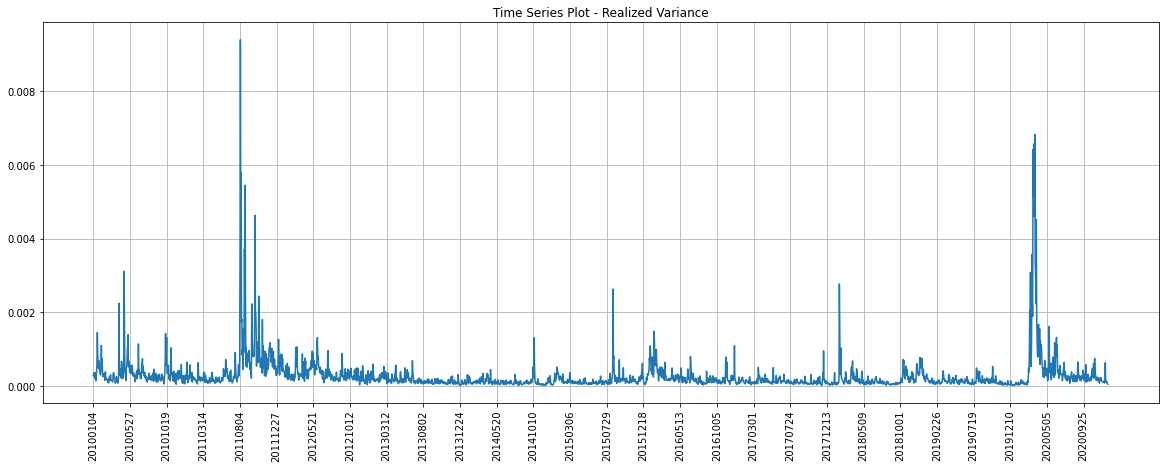

In [ ]:
# Descriptives RV

## convert to date
from datetime import datetime
#a = datetime.strptime(rv_data["DT"], '%Y%m%d').strftime('%m/%d/%Y')
#a

## plot RV over time
fig, ax = plt.subplots(figsize = (20, 7))
ax.plot(rv_data["outcome_rv"])
ax.set_title("Time Series Plot - Realized Variance")
ax.set_xticks(range(0,len(rv_data), 100))
ax.set_xticklabels(rv_data["DT"][::100], rotation = 90)
ax.grid()
plt.show()


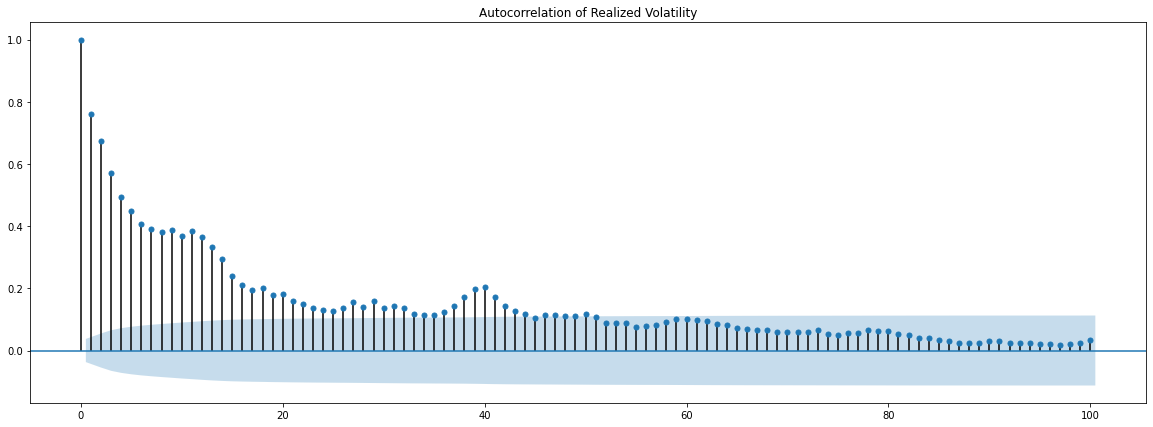

In [ ]:
## plot autocorrelation RV
import statsmodels.api as sm
fig, ax = plt.subplots(figsize = (20, 7))
sm.graphics.tsa.plot_acf(rv_data["outcome_rv"], lags=100, title = "Autocorrelation of Realized Volatility", ax =ax)
plt.show()

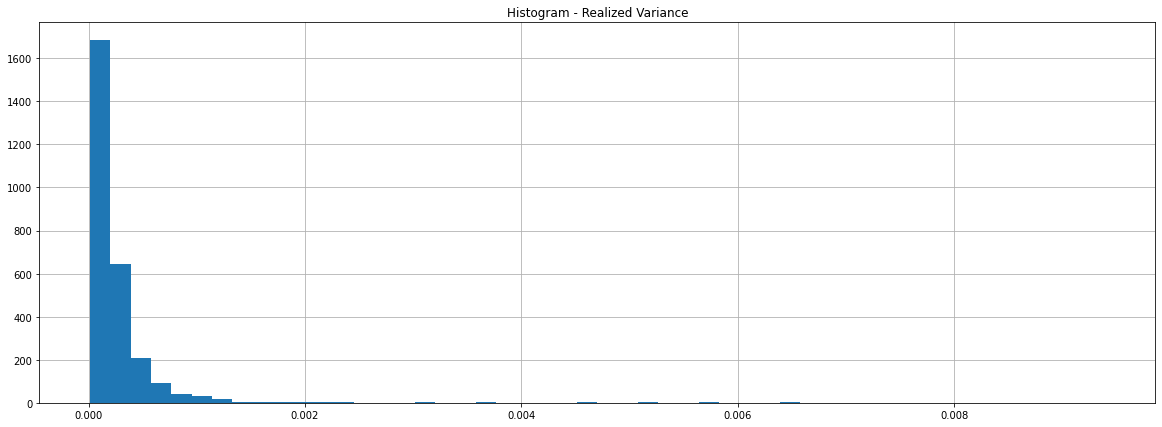

In [ ]:
## plot distribution RV
fig, ax = plt.subplots(figsize = (20, 7))
ax.hist(rv_data["outcome_rv"], bins=50, zorder = 20)
ax.set_title("Histogram - Realized Variance")
ax.grid(zorder = 0)
plt.show()

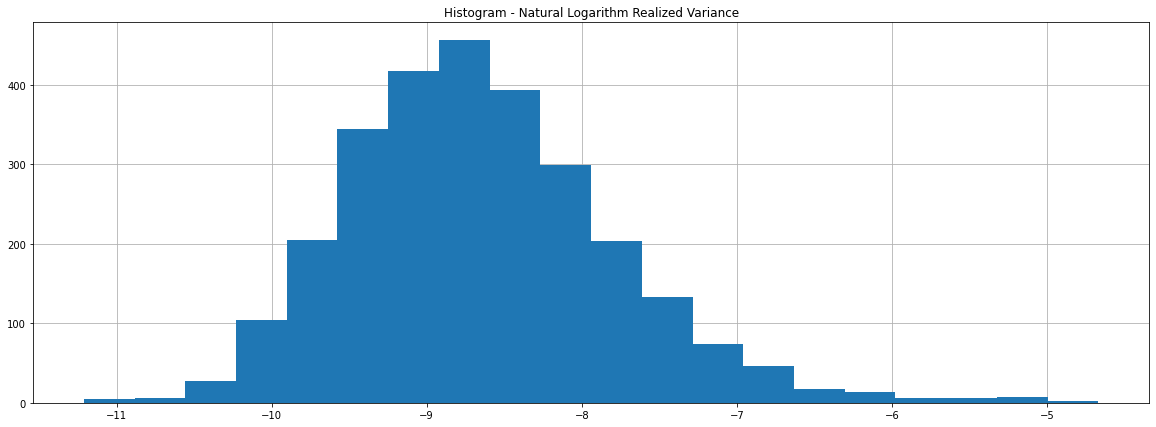

In [ ]:

## plot distribution log RV - not done in models yet.
fig, ax = plt.subplots(figsize = (20, 7))
ax.hist(rv_data["outcome_rv_log"], bins=20, zorder = 20)
ax.set_title("Histogram - Natural Logarithm Realized Variance")
ax.grid(zorder = 0)
plt.show()


## Model Estimation (external notebooks)

For details on the model estimation, refer to the following notebooks:

*   Feedforward neural-networks: FFN.ipynb
*   Long-Short-Term Memory model: LSTM.ipynb
* Gated Recurrent neural network model (similar to LSTM.ipynb): GRU.ipynb

The predictions of each estimated model are saved in the files a,b,c and required for the following section (Model Performance Comparison).


*   prediction results/
*   Listeneintrag



REMOVE GITTOKEN in code!!! (and other setup code)

ADD FILENAMES WITH PREDICTION THAT ARE REQUIRED.

UPDATE ALL FILE PATHS, github connection etc.

## Model Performance Comparison

We try to find the best model for forecasting realized variance and analyze the prediction quality.

### Combine Predictions and Compute Loss

In [ ]:
# Generate Dataframe for Predictions and True Values
# get model predictions
## validation
date_validation = pd.read_csv(path + "/prediction results/Simple_Model_Result_2.csv")["date"]
true = pd.read_csv(path + "/prediction results/Simple_Model_Result_2.csv")["RV"]
benchmark = rv_data[(rv_data["DT"]>=20161230) & (rv_data["DT"]<20181231)]["outcome_rv"].reset_index(drop=True) # dates from X to Y

ffn = pd.read_csv(path + "/prediction results/results_ffn_validation.csv")["pred_rv_e2_val"]

lstm1 = pd.read_csv(path + "/prediction results/Simple_Model_Result_2.csv")["predictions"]
lstm2_dense2 = pd.read_csv(path + "/prediction results/Simple_Model_3_Result_2.csv")["predictions"]
lstm1_feature_separate = pd.read_csv(path + "/prediction results/Model_Functional_Api_Result_2.csv")["predictions"]

gru1 = pd.read_csv(path + "/prediction results/GRU_Simple_Model_Result_2.csv")["predictions"]
gru2_dense2 = pd.read_csv(path + "/prediction results/GRU_Simple_Model_3_Result_2.csv")["predictions"]
gru1_feature_separate = pd.read_csv(path + "/prediction results/GRU_Model_Functional_Api_Result_2.csv")["predictions"]

validation = pd.concat([date_validation,true, benchmark,ffn,lstm1, lstm2_dense2, lstm1_feature_separate,gru1,gru2_dense2,gru1_feature_separate], axis = 1)
validation.columns = ["date","true","benchmark","ffn","lstm1","lstm2_dense2","lstm1_feature_separate","gru1","gru2_dense2","gru1_feature_separate"]


## test
date_test = pd.read_csv(path + "/prediction results/Simple_model_result_test.csv")["date"]
true = pd.read_csv(path + "/prediction results/Simple_model_result_test.csv")["RV"]
benchmark = rv_data[(rv_data["DT"]>=20181230) & (rv_data["DT"]<20201230)]["outcome_rv"].reset_index(drop=True) # dates from X to Y

ffn = pd.read_csv(path + "/prediction results/results_ffn.csv")["pred_rv_e2"]

lstm1 = pd.read_csv(path + "/prediction results/Simple_model_result_test.csv")["predictions"]
lstm2_dense2 = pd.read_csv(path + "/prediction results/Simple_model_3_result_test.csv")["predictions"]
lstm1_feature_separate = pd.read_csv(path + "/prediction results/model_functional_api_result_test.csv")["predictions"]

gru1 = pd.read_csv(path + "/prediction results/GRU_Simple_model_result_test.csv")["predictions"]
gru2_dense2 = pd.read_csv(path + "/prediction results/GRU_Simple_model_3_result_test.csv")["predictions"]
gru1_feature_separate = pd.read_csv(path + "/prediction results/GRU_Model_functional_api_result_test.csv")["predictions"]

test = pd.concat([date_test,true, benchmark,ffn,lstm1, lstm2_dense2, lstm1_feature_separate,gru1,gru2_dense2,gru1_feature_separate], axis = 1)
test.columns = ["date","true","benchmark","ffn","lstm1","lstm2_dense2","lstm1_feature_separate","gru1","gru2_dense2","gru1_feature_separate"]

# compute MSE & tabulate

mse_validation = pd.DataFrame(data = {"date": validation["date"]})
for x in validation.columns[2:]:
  mse_validation[x] = [(a-b)**2 for a,b in zip(validation["true"], validation[x])]

mse_test = pd.DataFrame(data = {"date": test["date"]})
for x in test.columns[2:]:
  mse_test[x] = [(a-b)**2 for a,b in zip(test["true"], test[x])]


In [ ]:
print(mse_validation.mean())
print(mse_test.mean())

benchmark                 3.195718e-08
ffn                       2.608893e-08
lstm1                     2.924613e-08
lstm2_dense2              3.552145e-08
lstm1_feature_separate    3.414153e-08
gru1                      2.944145e-08
gru2_dense2               2.869223e-08
gru1_feature_separate     2.770922e-08
dtype: float64
benchmark                 1.841449e-07
ffn                       3.001778e-07
lstm1                     1.986594e-07
lstm2_dense2              3.136342e-07
lstm1_feature_separate    2.075334e-07
gru1                      1.931476e-07
gru2_dense2               3.022916e-07
gru1_feature_separate     1.764069e-07
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


### Visual Comparison

**MSE Comparison**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFr

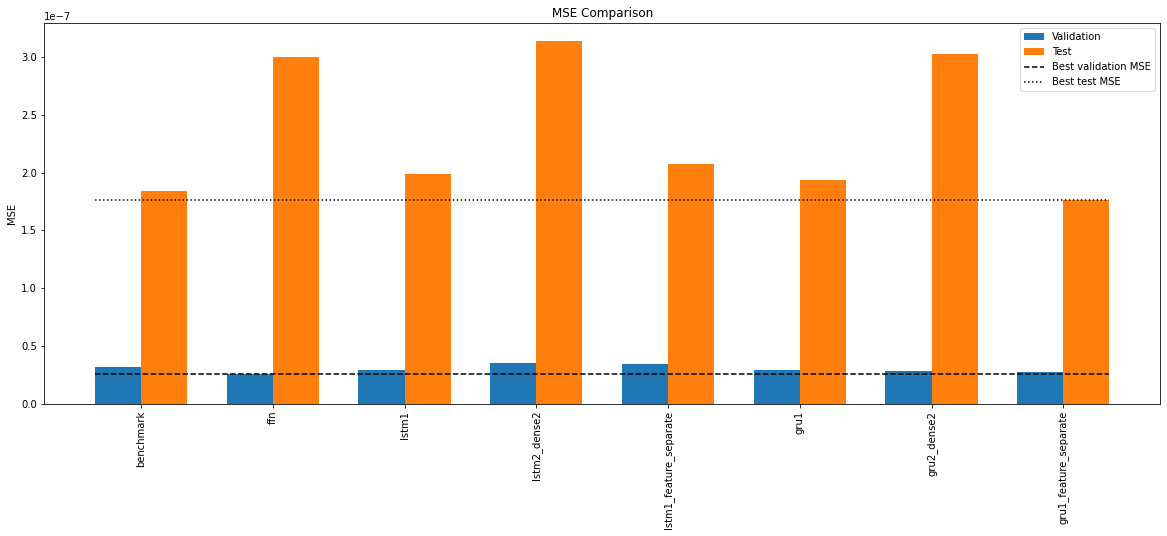

In [ ]:
# MSE comparison plots
fig, ax = plt.subplots(figsize = (20, 7))
width = 0.35
val = ax.bar([(x - width/2) for x in range(len(mse_validation.mean()))], mse_validation.mean(), width)
test_plot = ax.bar([(x + width/2) for x in range(len(mse_test.mean()))], mse_test.mean(), width)
val_line = ax.hlines(min(mse_validation.mean()), -width, len(mse_validation.mean()) + width-1, linestyle = "dashed")
test_line = ax.hlines(min(mse_test.mean()), -width, len(mse_test.mean()) + width-1, linestyle = "dotted")
ax.set_xticklabels(mse_validation.columns, rotation = 90)
ax.legend([val, test_plot, val_line, test_line], ["Validation", "Test", "Best validation MSE", "Best test MSE"])
ax.set_title('MSE Comparison')
ax.set_ylabel("MSE")
plt.show()

**MSE Time Series**

These time series plots show that the main MSE contribution is caused by a few timestamps.
Predictions in the COVID-19 crisis are specifically inaccurate. This is plausible since crises are harder to predict. However, these results question the value of the models since risk models are mainly used within crises.

In calm market times, MSE levels on the validation and test set are similar, which indicates that the difference in MSE levels could be caused by the COVID-19 crisis in the test data, and not by overfitting to the validation set. 

a) Including Outliers

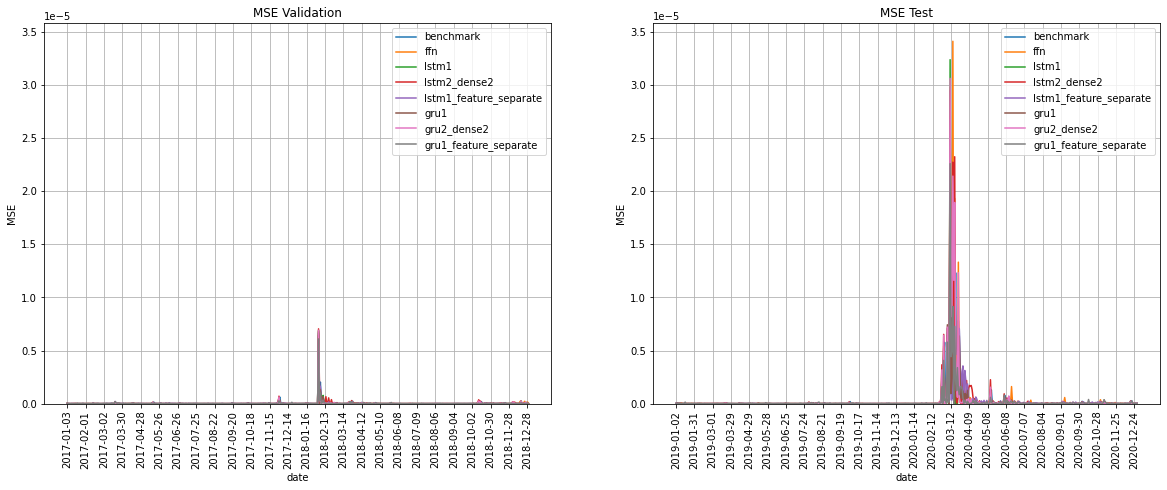

In [ ]:
# scale in percent for plots
import matplotlib.ticker as ticker

# plot predictions (auch für kleines Zeitinterval. Siehe Jules plots)
fig, axes = plt.subplots(1, 2, figsize=(20, 7))  #determine the size of the plot
for x in mse_validation.columns[1:]:
  axes[0].plot(range(len(mse_validation)),mse_validation[x], label = x)
axes[0].set_xticks(range(0, len(mse_validation), 20))
axes[0].set_xticklabels(mse_validation['date'][::20], rotation = 90)
axes[0].set_ylim(0, max(mse_test.max()[1:])*1.05)
axes[0].set_xlabel('date')
axes[0].set_ylabel('MSE')
axes[0].set_title('MSE Validation')
axes[0].grid(True)
axes[0].legend(loc='upper right')

# plot predictions (auch für kleines Zeitinterval. Siehe Jules plots)
for x in mse_test.columns[1:]:
  axes[1].plot(range(len(mse_test)),mse_test[x], label = x)
axes[1].set_xticks(range(0, len(mse_test), 20))
axes[1].set_xticklabels(mse_test['date'][::20], rotation = 90)
axes[1].set_ylim(0, max(mse_test.max()[1:])*1.05)
axes[1].set_xlabel('date')
axes[1].set_ylabel('MSE')
axes[1].set_title('MSE Test')
axes[1].grid(True)
axes[1].legend(loc='upper right')
plt.show()



b) Excluding Outliers

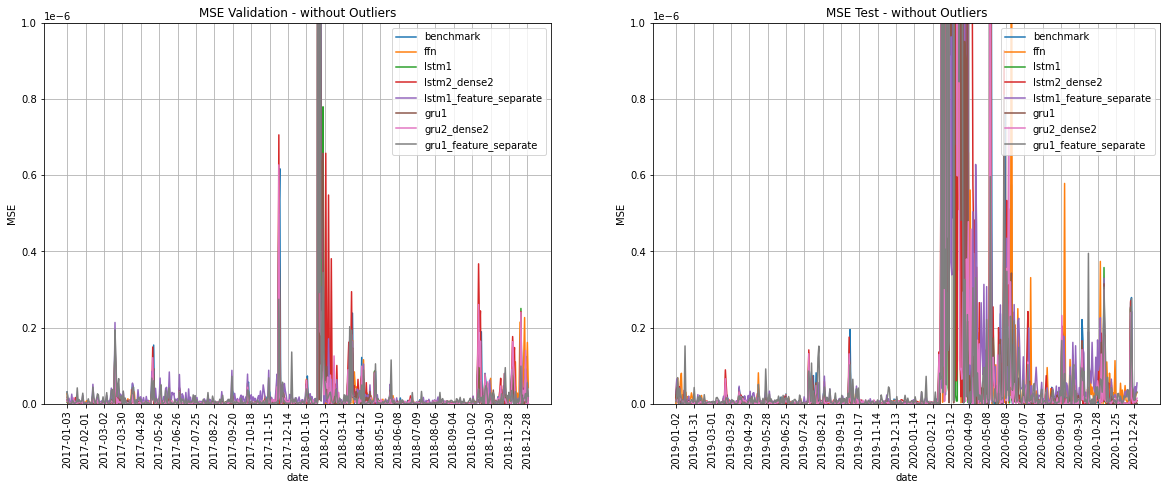

In [ ]:
# scale in percent for plots
import matplotlib.ticker as ticker

# validation
fig, axes = plt.subplots(1, 2, figsize=(20, 7))  #determine the size of the plot
for x in mse_validation.columns[1:]:
  axes[0].plot(range(len(mse_validation)),mse_validation[x], label = x)
axes[0].set_xticks(range(0, len(mse_validation), 20))
axes[0].set_xticklabels(mse_validation['date'][::20], rotation = 90)
axes[0].set_ylim(0, 10**(-6))
axes[0].set_xlabel('date')
axes[0].set_ylabel('MSE')
axes[0].set_title('MSE Validation - without Outliers')
axes[0].grid(True)
axes[0].legend(loc='upper right')

# test)
for x in mse_test.columns[1:]:
  axes[1].plot(range(len(mse_test)),mse_test[x], label = x)
axes[1].set_xticks(range(0, len(mse_test), 20))
axes[1].set_xticklabels(mse_test['date'][::20], rotation = 90)
axes[1].set_ylim(0, 10**(-6))
axes[1].set_xlabel('date')
axes[1].set_ylabel('MSE')
axes[1].set_title('MSE Test - without Outliers')
axes[1].grid(True)
axes[1].legend(loc='upper right')
plt.show()



**Prediction Time Series - 2 Samples**

By visual inspection, the predictions during the covid crisis and outside of the covid crisis seem to have a large variance, but tend to predict some movement in the true values. However, many model predictions simply lag behind the true values.

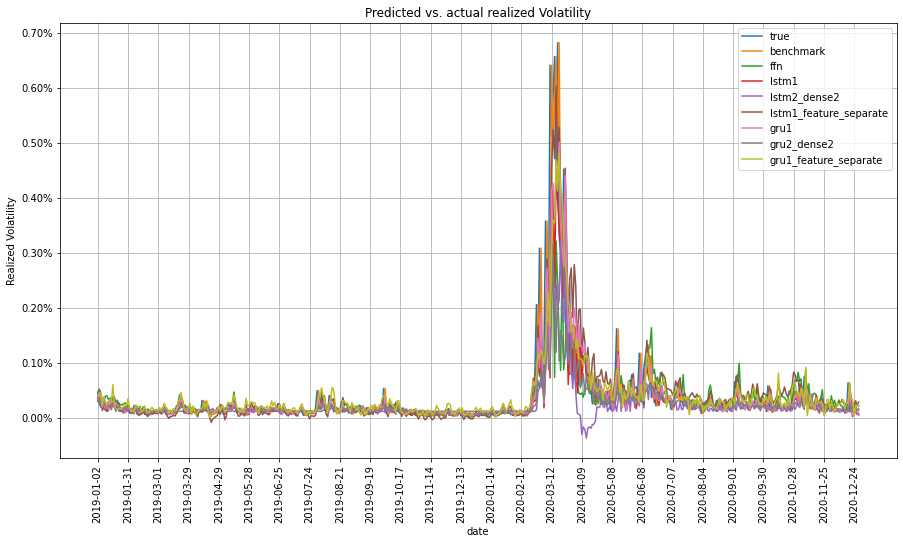

In [ ]:

# scale in percent for plots
import matplotlib.ticker as ticker

# plot predictions (auch für kleines Zeitinterval. Siehe Jules plots)
fig, ax = plt.subplots(figsize=(15, 8))  #determine the size of the plot
for x in test.columns[1:]:
  ax.plot(range(len(test)),test[x], label = x)
ax.set_xticks(range(0, len(test), 20))
ax.set_xticklabels(test['date'][::20], rotation = 90)
ax.set_xlabel('date')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_ylabel('Realized Volatility')
ax.set_title('Predicted vs. actual realized Volatility')
ax.grid(True)
ax.legend(loc='upper right')
plt.show()



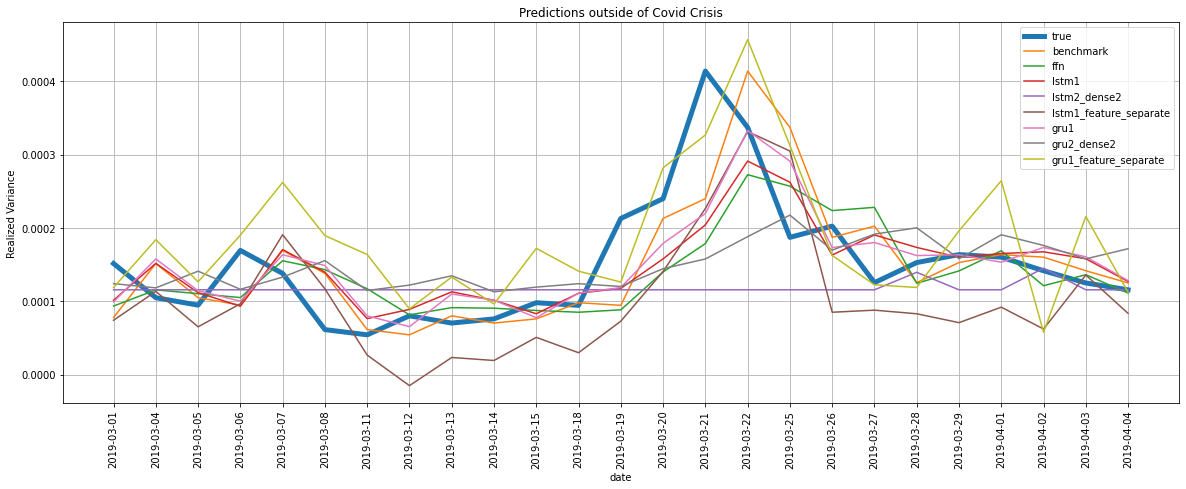

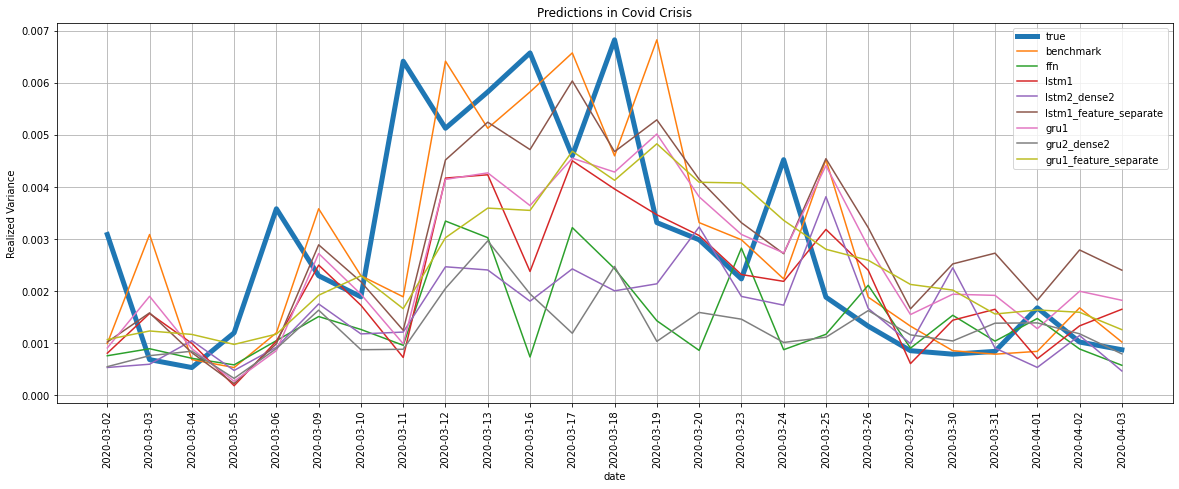

In [ ]:

# plot predictions nocovid
test_cut = test[(test["date"] >= "2019-03-01") & (test["date"] <= "2019-04-04")]
fig, ax = plt.subplots(figsize=(20, 7))  #determine the size of the plot
ax.plot(range(len(test_cut)),test_cut["true"], label = "true", linewidth = 5)
for x in test_cut.columns[2:]:
  ax.plot(range(len(test_cut)),test_cut[x], label = x)
ax.set_xticks(range(0, len(test_cut), 1))
ax.set_xticklabels(test_cut['date'][::1], rotation = 90)
ax.set_xlabel('date')
ax.set_ylabel('Realized Variance')
#ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_title('Predictions outside of Covid Crisis')
ax.grid(True)
ax.legend(loc='upper right')
plt.show()


# plot predictions covid
test_cut = test[(test["date"] >= "2020-03-01") & (test["date"] <= "2020-04-04")]
fig, ax = plt.subplots(figsize=(20, 7))  #determine the size of the plot
ax.plot(range(len(test_cut)),test_cut["true"], label = "true", linewidth = 5)
for x in test_cut.columns[2:]:
  ax.plot(range(len(test_cut)),test_cut[x], label = x)
ax.set_xticks(range(0, len(test_cut), 1))
ax.set_xticklabels(test_cut['date'][::1], rotation = 90)
ax.set_xlabel('date')
ax.set_ylabel('Realized Variance')
#ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_title('Predictions in Covid Crisis')
ax.grid(True)
ax.legend(loc='upper right')
plt.show()


**Prediction Scatter Plots**

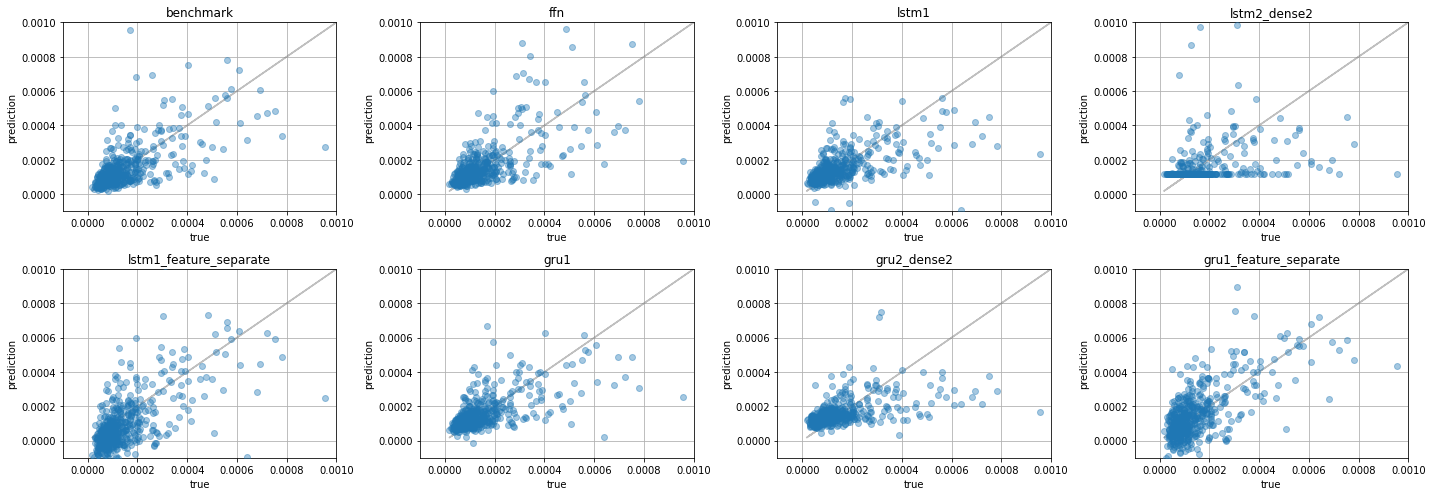

In [ ]:
# scatter plots: true and model prediction
rows = 2
columns = 4

fig, axes = plt.subplots(rows, columns, figsize = (20, 7))
i = 2
for r in range(rows):
  for c in range(columns):
    if (i+c)==len(validation.columns):
      break
    axes[r, c].scatter(validation["true"], validation[validation.columns[i+c]], zorder = 20, alpha = 0.4)
    axes[r, c].plot(validation["true"], validation["true"], c = "grey", alpha = 0.5)
    axes[r, c].grid(zorder = 0)
    axes[r, c].set_ylim(-0.0001, 0.001)
    axes[r, c].set_xlim(-0.0001, 0.001)
    axes[r, c].set_xlabel('true')
    axes[r, c].set_ylabel('prediction')
    axes[r, c].set_title(validation.columns[i+c])
  i += 4

# axes[r,c].remove()
fig.tight_layout()
plt.show()

## Project Summary

*   Realized variance is hard to predict during a crisis.
* Models capture time persistency of realized variance reasonably well
*   Some models predict negative realized variances.
*   Best neural network model: GRU with time-series and non-time series component (gru1_feature_separate).
*   The benchmark model is always among the best performing models.






## Future Work

*   Model the natural logarithm of realized volatility to ensure positivity
*   Different stocks or other assets
*   Longer prediction horizon
* HAR model (Corsi 2009) as benchmark model
* Add market sentiment features
*   Additional features
* Shared parameters across multiple stocks instead of one model for each stock
* Interpretability of features (SHARPLY, LIME)
* Economic forecast evaluation using portfolio or value-at-risk applicattion
*   ...


